<center>

# Discrete Event Systems

## Home Assignment 3

### Model Checking with $\mu%$-Calculus & Controlling through Q-Learning
</center>

- - -

# Introduction

The first objective of this home assignment is to deepen the understanding of temporal logic specifications and model checking algorithms based on $\mu$-calculus. You will achieve that through implementing a fixed-point algorithm for a particular _CTL*_ specification and test it out on a booking problem of variable size. 

The second objective is to obtain a basic understanding of a central Reinforcement Learning algorithm called *Q-learning*.

This home assignment is performed in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) on Canvas**

## Comments and Recommendations
As always:
* The following resources will be of great help to you for this assignment:
 * Lecture Notes
 * [Python docs](https://docs.python.org/3/)
 * [Google](https://www.google.com)
* This assignment is written for Python 3.5 or later!
* We will test your code with additional edge cases. So convince yourself that everything is correct before you submit.
* This assignment makes use of the Python packages [numpy](https://docs.scipy.org/doc/numpy/) and [matplotlib](https://matplotlib.org/index.html). Make sure to have it installed.

In [2]:
%matplotlib notebook

try:
    import numpy as np
except ImportError:
    print("You need to install numpy! Open a command prompt and run 'pip install numpy'")

try:
    import matplotlib.pyplot as plt
except ImportError:
    print("You need to install matplotlib! Open a command prompt and run 'pip install matplotlib'")

- - -

# Part 1 - Model Checking with $\mu-$Calculus

Imagine you are employed by a company, but you are quite unhappy recently, because the system you are working with (for instance, a manufacturing cell, but could be anything else) exhibits some strange behavior and just freezes randomly. So, you decide to model the system (i.e. manufacturing cell, etc) and analyze it with the methods from your favorite course at university. Hence, you come up with the petri net $P_1$:
![petri net](fig/petri_net.png)
Two parallel processes require two resources $R_1$ and $R_2$ for their operations. This is a classic booking problem. Although appearing simple, this system may exhibit undesirable behavior. For the majority of Part 1 of the assignment we will work with this system. 

In [3]:
from util import PetriNet
from util import Place, Arc
from util import plot_petrinet


def make_petrinet(p11_tokens, p21_tokens, R1_tokens, R2_tokens):
    return PetriNet(places=[Place('p11', p11_tokens), Place('p12', 0),
                            Place('p21', p21_tokens), Place('p22', 0),
                            Place('R1', R1_tokens), Place('R2', R2_tokens)],
                    transitions={'a1', 'b1', 'a2', 'b2'},
                    arcs={Arc('p11', 'a1', 1),
                          Arc('a1', 'p12', 1),
                          Arc('p12', 'b1', 1),
                          Arc('b1', 'p11', 1),
                          Arc('R1', 'a1', 1),
                          Arc('R1', 'b2', 1),
                          Arc('b1', 'R1', 1),
                          Arc('b2', 'R1', 1),
                          Arc('R2', 'a2', 1),
                          Arc('R2', 'b1', 1),
                          Arc('b1', 'R2', 1),
                          Arc('b2', 'R2', 1),
                          Arc('p21', 'a2', 1),
                          Arc('a2', 'p22', 1),
                          Arc('p22', 'b2', 1),
                          Arc('b2', 'p21', 1)})


P_1 = make_petrinet(p11_tokens=3, p21_tokens=2, R1_tokens=2, R2_tokens=1)

We have also implemented a function for you in the PetriNet class that generates the corresponding reachability graph.

P_1:


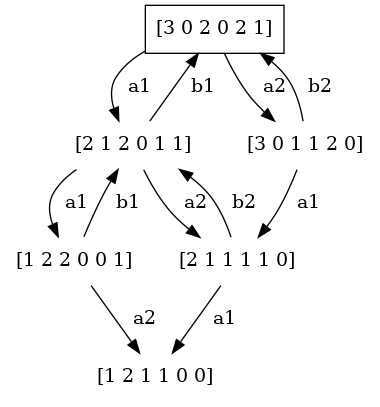

In [4]:
from util import plot_digraph

print('P_1:')
plot_digraph(P_1.make_reachability_graph(), 'fig/P_1_reach_graph')

To be able to use $\mu$-calculus to check the Petri net model, we need to transform it into a transition system, though. 

---

## Transition Systems

In this assignment, we will work with a more general model for discrete event systems called __Transition System__. A transition system $G$ is defined by a 6-tuple $G = \langle X, \Sigma, T, I, AP, \lambda \rangle$ where $X$ is a set of states, $\Sigma$ is a finite set of events, $T \subseteq X \times T \times X$ is a transition relation, where a transition $t = (x, a, x') \in T$, includes the source state $x$, the event label $a$, and the target state $x'$, $I \subseteq X$ is a set of possible initial states, $AP$ is a set of atomic propositions, and $\lambda: X \mapsto 2^{AP}$ is a state labeling function. A transition system  $G$ without the state labels, where $AP$ and $\lambda$ are excluded from $G$ is obviously an automaton without marked and forbidden states.

In order to implement a data structure corresponding to a transition system, we introduce a new class of _State_ objects.

In [5]:
class State(object):
    
    def __init__(self, name, labels=None):
        """
        Constructor  of the state.
        
        :param name: String. Default atomic proposition of the state
        :param labels: Set of atomic propositions that a true in the state
        """
        self.name = name
        assert labels is None or type(labels) is set
        self.labels = {name} if not labels else labels | {name}
    
    def __str__(self):
        """Prints the state in a pretty way."""
        return 'name: {} & ' \
               'labels: {}'.format(self.name, self.labels)
        
    def is_satisfied(self, atomic_proposition):
        """Checks whether the atomic proposition is statisfied in the state."""
        return atomic_proposition in self.labels

That allows us to define the _TransitionSystem_ class:

In [6]:
from util import Transition


class TransitionSystem(object):

    def __init__(self, states, init, events, trans):
        """
        This is the constructor of the transition system.

        At creation, the automaton gets the following attributes assigned:
        :param states: A set of States
        :param init: A set of initial States
        :param events: A set of events
        :param trans: A set of transitions
        """
        assert isinstance(states, set)
        self.states = states
        assert isinstance(init, set)
        self.init = init
        assert isinstance(events, set)
        self.events = events
        assert isinstance(trans, set)
        self.trans = trans

    def __str__(self):
        """Prints the transition system in a pretty way."""
        states_str = '{\n\t' + ',\n\t'.join(
            [str(s) for s in self.states]) + '\n\t}'
        init_str = '{\n\t' + ', '.join([str(s.name) for s in self.init]) + '\n\t}'
        trans_str = '\n\t'.join(
            ['{} --{}--> {},'.format(t.source.name, t.event, t.target.name) for t in self.trans])
        trans_str = '{\n\t' + trans_str + '\n\t}'
        return 'states: \n\t{}\n' \
               'init: \n\t{}\n' \
               'events: \n\t{}\n' \
               'transitions: \n\t{}\n'.format(
                   states_str, init_str, self.events, trans_str)

    def __eq__(self, other):
        """Checks if two transition systems are the same"""
        if type(other) is type(self):
            return self.__dict__ == other.__dict__
        return False

Now, we can translate our Petri net $P_1$ of the booking problem that we are working with into a *TransitionSystem* via its reachability graph.

T_1:


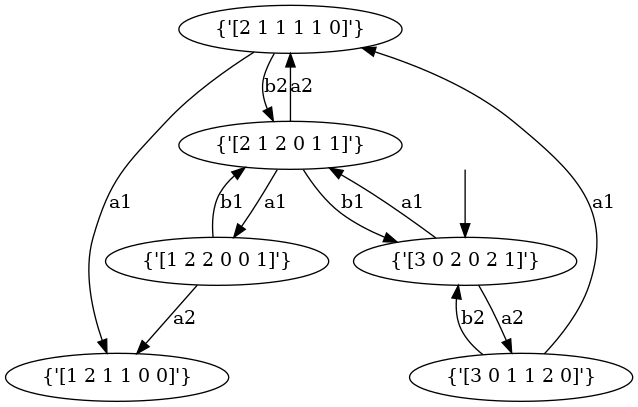

In [7]:
from util import plot_transitionsystem


def make_transition_system(petri_net):
    """Transforms a PetriNet to a TransitionSystem."""
    G = petri_net.make_reachability_graph()
    states = {State(n) for n in G.nodes}
    
    def get_state(node):
        for s in states:
            if s.name == node:
                return s
    
    init = {get_state(G.init)}
    events = petri_net.transitions
    trans = {Transition(get_state(e.source), e.label, get_state(e.target)) for e in G.edges}
    return TransitionSystem(states, init, events, trans)


T_1 = make_transition_system(P_1)
print('T_1:')
plot_transitionsystem(T_1, 'fig/P_1_transition_system')

---

## Task 1.1 *[2p]*

### ___CTL*___-Specification to $\mu$-Calculus *[2p]*

In this assignment, you will implement the $\mu$-calculus algorithms for the booking problem $P_i$ shown above. Specifically, you will check its TransitionSystem model $T_i$ for the following temporal logic specification given in ___CTL*___:

<center>
    $\varphi_i = \forall \square \exists \lozenge m_i$,
</center>
with $m_i$ indicating a specific initial marking of $P_i$ (e.g. $m_1 = [3 0 2 0 2 1]$). 

* In simple words, what does this specification $\varphi_1 = \forall \square \exists \lozenge m_1$ say and why does it specify a desired behavior? Write your answer below. ***[1p]***

This specification has to mean that "from all states we should always eventually reach a marked state". Symbols $\forall$ and $\square$ go for "from all states" and "we should always", relevantly. Symbol $\lozenge$ stays for "eventually reach". Symbol $\exists$ indicates that from each state there is always a possibility to reach a marked state. For instance, if some state can reach a marked state in one transition, but it also has a self-loop transition, and it keeps doing self-loops to infinity not reaching the marked state subsequently, but anyway the system always has the opportunity to reach a marked state so the expression is satisfied. 

Now, 
* transform the ___CTL*___ formula $\varphi_1$ to $\mu$-calculus set expressions. Show also intermediate results. ***[1p]***
* *Note*: [This webpage](http://detexify.kirelabs.org/classify.html) may be useful for finding the right LaTex symbols.
* *Hint:* The double square brackets $[\![p]\!]$ can be done with [ \ ! [ p ] \ ! ] within the math environment. The LaTeX environments of the [amsmath package](https://tex.stackexchange.com/questions/3782/how-can-i-split-an-equation-over-two-or-more-lines) are also supported (equation, multiline and split).


$$ \forall \square \exists \lozenge m_{1} \rightarrow \nu z.(\mu y.m_{1} \vee \exists \bigcirc y) 
\wedge \forall \bigcirc z $$

$$ \nu z.(\mu y.m_{1} \vee \exists \bigcirc y) \wedge \forall \bigcirc z \rightarrow \nu Z.(\mu Y.[\![m_{1}]\!] \cup
Pre^{\exists}(Y)) \cap Pre^{\forall}(Z) $$

---

## Task 1.2 - $\text{Pre}^\exists$ Operator *[1p]*

$\mu$-calculus includes next modality functions $f \in \mathcal{F}$, namely $f = \exists \bigcirc$ and $f = \forall \bigcirc$. You will implement $f = \exists \bigcirc$ as __predecessor set operation__ in this section of the assignment. We will need this operator to check our model of the booking problem. 

This set operator is defined as

<center>
   $\text{Pre}^\exists(Y) = \{x \mid (\exists a \in \Sigma(x))\delta(x, a) \subseteq Y \}$, 
</center>
where $x \in X$ and $Y \in 2^X$.

Now,
* implement the $\text{Pre}^\exists$ set operator in the `pre_exists` function.
* _Hint:_ The inbuilt Python function [`any`](https://docs.python.org/3/library/functions.html#any) might be useful here.

In [8]:
# You might want to use one of these...
from util import filter_trans_by_source, filter_trans_by_events, filter_trans_by_target
from util import extract_elems_from_trans, flip_trans

In [9]:
def pre_exists(Y, ts):
    """
    Returns the new set of states for which the exists next modality is true.
    
    :param Y: Set of States
    :param ts: TransitionSystem
    """
    # YOUR CODE HERE
    filt = filter_trans_by_target(ts.trans,Y)
    extr = extract_elems_from_trans(filt,'source')
    return extr

In [10]:
# space for your own tests

In [11]:
s1 = State(1)
s2 = State(2)

T0 = TransitionSystem({s1}, {s1}, set(), set())
assert pre_exists(set(), T0) == set()
assert pre_exists({s1}, T0) == set()

T1 = TransitionSystem({s1}, {s1}, {'a'}, {Transition(s1, 'a', s1)})
assert pre_exists(set(), T1) == set()
assert pre_exists({s1}, T1) == {s1}

T2 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s2)})
assert pre_exists(set(), T2) == set()
assert pre_exists({s1}, T2) == set()
assert pre_exists({s2}, T2) == {s1}
assert pre_exists({s1, s2}, T2) == {s1}

This $\text{Pre}^\forall$ set operator for $f = \forall \bigcirc$ is defined as

<center>
   $\text{Pre}^\forall(Y) = \{x \mid (\forall a \in \Sigma(x))\delta(x, a) \subseteq Y \}$, 
</center>
where $x \in X$ and $Y \in 2^X$.

An implementation is given below.

In [12]:
def pre_forall(Y, ts):
    """
    Returns the new set of states for which the forall next modality is true.
    
    :param Y: Set of States
    :param ts: TransitionSystem
    """
    def all_t_into_Y_from(source):
        out_transitions = filter_trans_by_source(ts.trans, {source})
        return all({t.target in Y for t in out_transitions})
    
    Y = {x for x in ts.states if all_t_into_Y_from(x)}
    return Y

---

## Task 1.3

### Model Checking through Fixed-Point Iteration *[2p]*

After having reformulated $\varphi_i = \forall \square \exists \lozenge m_i$ as $\mu$-calculus set expressions, and having obtained an implementation of both $\text{Pre}^\exists$ and $\text{Pre}^\forall$, we can start on the actual model checking algorithm. 

* Implement the function `is_always_eventually_satisfied` that takes as inputs an atomic proposition (e.g. $m_i$) and a TransitionSystem. It then checks whether the TransitionSystem satisfies $\varphi_i$. ***[2p]***
* _Hint:_ You need to implement both a least fixed-point iteration $\mu Z$ and a greatest fixed-point iteration $\nu Y$.

In [13]:
def is_always_eventually_satisfied(m_i, ts):
    """
    Checks if a TransitionSystem always eventually satisfies an atomic proposition.
    
    :param m_i: String/integer. Atomic proposition
    :param ts: TransitionSystem to check
    """
    satisfied = False
    # YOUR CODE HERE
    states = ts.states
    m_i_states = set()
    for st in states:
        if m_i in st.labels:
            m_i_states.add(st)
    
    # Least-fixed point:
    Z = set()      
    while True:
        ZZ = m_i_states|pre_exists(Z,ts)
        if ZZ == Z:
            X = ZZ
            break    
        Z = ZZ
      
    # Greatest-fixed point:
    Y = states;
    while True:
        YY = X&pre_forall(Y,ts)
        if YY == Y:
            break    
        Y = YY
        
    satisfied = ts.init.issubset(Y)
    return satisfied


m_1 = '[3 0 2 0 2 1]'
print('T_1 {} satisfy phi_1!'.format('does' if is_always_eventually_satisfied(m_1, T_1) else 'does NOT'))

T_1 does NOT satisfy phi_1!


In [14]:
# space for your own tests
st0 = State(0,{'p'})
st1 = State(1,{'p'})
st2 = State(2)
st3 = State(3,{'p','q'})

T = TransitionSystem({st0,st1,st2,st3}, {st0}, {'a','b','c','d','e'}, 
                     {Transition(st0, 'a', st1),
                     Transition(st1, 'b', st1),
                     Transition(st0, 'c', st2),
                     Transition(st2, 'd', st3),
                     Transition(st3, 'e', st3),
                     Transition(st1, 'd', st3),
                     })
assert is_always_eventually_satisfied('p', T) == True

In [15]:
s1 = State(1, {'AP'})
s2 = State(2)

T0 = TransitionSystem({s1}, {s1}, set(), set())
assert is_always_eventually_satisfied(1, T0) == True
assert is_always_eventually_satisfied('AP', T0) == True

T1 = TransitionSystem({s1}, {s1}, {'a'}, {Transition(s1, 'a', s1)})
assert is_always_eventually_satisfied(1, T1) == True

T2 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s2)})
assert is_always_eventually_satisfied(1, T2) == False
assert is_always_eventually_satisfied(2, T2) == True

T3 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s1), Transition(s1, 'a', s2)})
assert is_always_eventually_satisfied(1, T3) == False
assert is_always_eventually_satisfied(2, T3) == True

T4 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s1), 
                                              Transition(s1, 'a', s2), 
                                              Transition(s2, 'a', s2)})
assert is_always_eventually_satisfied(1, T4) == False
assert is_always_eventually_satisfied(2, T4) == True

s3 = State(3)
s4 = State(4, {3})
T5 = TransitionSystem({s1, s2, s3, s4}, {s1, s2}, {'a', 'b'}, 
                      {Transition(s1, 'a', s3),
                       Transition(s1, 'b', s4),
                       Transition(s2, 'a', s4)})
assert is_always_eventually_satisfied("AP", T5) == False
assert is_always_eventually_satisfied(2, T5) == False
assert is_always_eventually_satisfied(3, T5) == True
assert is_always_eventually_satisfied(4, T5) == False

T6 = TransitionSystem({s1, s2, s3, s4}, {s1}, {'a', 'b'}, 
                      {Transition(s1, 'a', s2),
                       Transition(s1, 'b', s3),
                       Transition(s2, 'a', s1),
                       Transition(s2, 'b', s4),
                       Transition(s3, 'a', s1),
                       Transition(s3, 'b', s4),
                       Transition(s4, 'a', s2)})
assert is_always_eventually_satisfied(1, T6) == True
assert is_always_eventually_satisfied(2, T6) == True
assert is_always_eventually_satisfied(3, T6) == True
assert is_always_eventually_satisfied(4, T6) == True

---

## Task 1.4

### Solving the Booking Problem *[1p]*

It seems that there is an issue with the booking of the resources in the system (the Petri net from earlier) at some point. And that even pertains when we scale the system.

In [16]:
# e.g. multiplying all tokens by factor 7
m_2 = '[21 0 14 0 14 7]'
T_2 = make_transition_system(make_petrinet(p11_tokens=21, p21_tokens=14, R1_tokens=14, R2_tokens=7))
print('T_2 {} satisfy phi_2!'.format('does' if is_always_eventually_satisfied(m_2, T_2) else 'does NOT'))

# Uncomment the next line to plot the transition system

plot_transitionsystem(T_2, 'fig/T_2')

T_2 does NOT satisfy phi_2!


Given that observation:

* Change $P_1$ so that the booking problem is resolved. Elements of the original structure of the Petri net (places and arcs) must not be removed in that. ***[1p]***
* *Hint:* Based on the model you could figure out what the problem is, and start to experiment with the model to find a way to prevent the problem from occurring. 

T_3 does satisfy phi_3!
P_3:


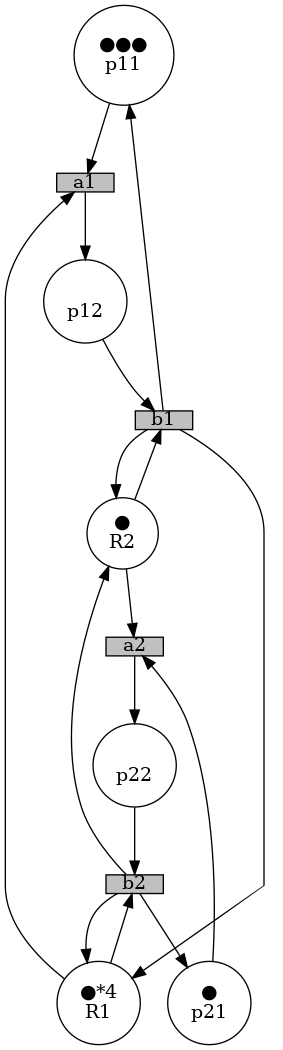

In [17]:
from util import array_str

def make_fixed_petrinet():
    """Makes a new, altered, issue-free version of P_1"""
    return make_petrinet(p11_tokens=3, p21_tokens=1, R1_tokens=4, R2_tokens=1)

P_3 = make_fixed_petrinet()
T_3 = make_transition_system(P_3)
print('T_3 {} satisfy phi_3!'.format('does' if is_always_eventually_satisfied(array_str(P_3.init_marking), T_3)
                                     else 'does NOT'))
print('P_3:')
plot_petrinet(P_3, 'fig/P_3')

# Uncomment the two next lines in order to plot the transition system:
# print('T_3:')
# plot_transitionsystem(T_3, 'fig/P_3_transition_system')

Finally, you found a configuration of your model for which everything is fine. You get super excited and burst into your boss' office, and exclaim: _"I know how to fix our problem with the system! Give me a raise!"_ And your boss gets super excited and asks you how to solves her greatest nightmare. Obviously, you cannot say now: _"We need to get a big can of paint and draw some circles and arrows on the floor!"_ (except maybe if you know some ancient magic ritual against booking problems). No, you need to translate your model changes into your boss' world, i.e. do we need to change the process, buy new equipment, re-program the controllers, etc. Also, you cannot decide that one of the resources is no longer needed for processing or remove one of the two processes altogether. In other words, the places, transitions and arcs of the original petri net $P_1$ must remain. You can add places and so on, or adjust the number of tokens as long  as the original structure is part of the new model and you can motivate your changes in words that are understandable to your manager, that knows nothing about DES.

* Describe briefly in words how you could implement your proposed changes in the real system. ***[1p]***

Let's imagine that P1 is a company where R1 and R2 are two types of robots in it, let's say R1 are robot1 and R2 are robot2. The number of tokens in each of them indicates how many robots are available for any task to solve. And there are two types of tasks to solve in that company. p11 and p12 correspond to task 1, p21 and p22 correspond to task 2.

The initial number of tokens in p11 and p21 represent the number of each task that should be solved simultaneously. Number of tokens in p12 and p22 indicate the number of tasks being solved now for each type of the task. A robot1 (R1) is needed to start solving task 1 or in Petri net language do a1. And a robot2 (R2) is needed to start solving task 2 (do a2). In order to finalize the task 1 (do b1) a robot2 (R2) is needed. And to finalize the task 2 (do b2) an robot1 (R1) is needed. In the given system if we try to simultaneously do two task 1 (p12 = 2) and one task 2 (p22 = 1) we will run out of both robot2 (R2) and robot1 (R1) and none of the task could be finished in that case, so the system is paralized.

We can propose to our boss that for task 1 we can either buy two more robot1 (two more tokens in R1) or reduce the number of tasks of type 1 that should be solved simultaneously (two less tokens in p11). Or we can propose that for task 2 we can either buy two more robot2 (two more tokens in R2)  or reduce the number of tasks of type 2 that should be solved simultaneously (two less tokens in p21).

In our solution we choose to buy two more robot1 (add two more tokens to R1). In that case we will avoid any freezing state and keep the production rate (tokens in p11). 

## Bonus Task (optional)

* Can you derive a general rule to avoid the booking problem for the given Petri net structure of $P_1$, that is a booking problem with two parallel processes? If yes, explain it with a few words. ***[+1p]***

In order to avoid paralyzing (freezing) state we always need to have at least one robot of any type available. This means that for any of the tasks, number of robots that are required to start solving it has to be bigger than the number of tasks of that type that should be solved simultaneously. In mathematical language it means that at least one of these inequalities have to be satisfied:  


$$ R_{1}> p_{11}   $$
$$ R_{2}> p_{21}   $$

---

# Part 2: Reinforcement Learning

After having had a tremendously successful day at work, you call your friends to share the story of how you single-handedly solved your company's booking issue using $\mu$-calculus. All agree that this needs to be celebrated accordingly, and so you meet up at Andra Långgatan. Your likely future promotion is cause for a long and jolly evening, and when you finally decide to go home, it has become quite dark already. To make matters even worse, a strong wind is blowing from south/south-west, and you seem to have forgotten the way to your home in Gamlestaden (for whatever reason - blame it on the long day thinking about temporal logic if you'd like). You conclude that your best option would be to start walking in some direction in the hope of finding your home eventually. But careful! If you walk too close alongside the Göta Älv, the strong wind might blow you into the river. In addition to the unpleasant experience, the river will take you back to Järntorget and you need to start your journey home all over again. And if that wasn't bad enough yet, you might get convinced to join some _"late-night studying"_ if you pass by J. A. Pripps at Chalmers.   

In this part of the assignment, you will implement a Reinforcement Learning algorithm called Q-learning. Reinforcement Learning uses data sampled from the plant (or the environment in RL terms) to derive an optimal controller - just right for finding your way back home.

Let us look at the environment first. As part of the task, you will need to decide how much a visit to J.A. Pripps is worth to you. Note that this is strictly speaking not an element of the Q-learning algorithm, but rather an element of the reward function. While many publications on RL assume that the reward function is given, in practice, designing a good reward function, that enables the RL agent to learn the wanted behavior, is a difficult task. 

In [18]:
%matplotlib notebook
import random 
from time import sleep

import matplotlib.pyplot as plt

from util import set_up_GBG, plot_pos, plot_Q, plot_average_r, clear_plot


class WindyGothenburg(object):

    def __init__(self, pripps_reward=1.828, test=False):
        """The constructor of the grid world WindyGothenburg"""
        self.w = 12
        self.h = 12
        self.states = {(i, j) for i in range(self.w + 1) for j in range(self.h + 1)}
        self.actions = {'north', 'east', 'south', 'west'}
        
        self._jarntorget = (0, self.h)
        self._home = (self.w, self.h)
        self._gota_alv = {(k, self.h) for k in range(2, self.w)}
        self._chalmers = (3, 2)
        assert 0.01 <= pripps_reward <= 10
        self._pripps_reward = pripps_reward
        self._current_state = self._jarntorget    
        
        # for rendering
        self._test = test
        if not self._test:
            self.fig, self.gw, self.sp = set_up_GBG(self.w, self.h, self._jarntorget, 
                                                    self._chalmers, self._home)
            self.plot_elems = ()
            self.last_pos = None
        
    def _get_next_state(self, state, action):
        """The transition function"""
        i, j = state
        i = i + 1 if random.random() < 0.05 else i # wind blows you to the east
        j = j + 1 if random.random() < 0.1 else j # wind blows you to the north
        if action == 'north':
            j += 1
        elif action == 'east':
            i += 1
        elif action == 'south':
            j -= 1
        elif action == 'west':
            i -= 1
        # ensure the next state is within the grid
        i = max(0, min(i, self.w))
        j = max(0, min(j, self.h))
        return (i, j) # next state

    def step(self, action):
        """
        Advances the simulation by one step
        
        :param action: the control action to apply
        """
        assert action in self.actions
        
        next_state = self._get_next_state(self._current_state, action)
        self._current_state = next_state
        
        if next_state == self._home:
            reward = 100
            done = True
        elif next_state in self._gota_alv:
            reward = -10
            done = True
        elif next_state == self._chalmers:
            reward = random.choice([0, self._pripps_reward])
            done = False
        else:
            reward = 0
            done = False
            
        return next_state, reward, done
    
    def reset(self):
        """Must be called if done == True"""
        self._current_state = self._jarntorget
        return self._current_state
    
    def render(self, Q=None, average_reward=None, episode=None):
        """Renders the environment"""
        assert not self._test, 'Disable test mode for rendering'
        if self.last_pos:
            self.last_pos.remove()
        if self.plot_elems:
            clear_plot(*self.plot_elems)
        self.last_pos = plot_pos(self.gw, self._current_state)
        if Q:
            # Plots the contours of max_u Q(*|x) for each x
            # Plots also the direction of argmax_u Q(*|x) for each x
            self.plot_elems = plot_Q(self.gw, Q, self.w, self.h) 
        if average_reward:
            # Tracking learning over episodes
            assert episode is not None, 'Provide the number of the current episode.'
            plot_average_r(self.sp, average_reward, episode)
        self.fig.canvas.draw()
        sleep(0.001) # So you can enjoy the pretty plot
    
    def close(self):
        if not self._test:
            plt.close(self.fig)

The RL algorithm that you will implement is as follows:

**Algorithm 1.** Q-learning$(\alpha, \epsilon, \gamma)$

>Initialize $Q(x,a)$ arbitrarily
>
>**for all** episodes **do**
>
>>Initialize $x$
>>
>>**for all** steps of episode  **do**
>>>
>>>Choose $a$ in $x$ using policy derived from $Q$ (e.g. $\epsilon$-greedy)
>>>
>>>Take action $u$, observe $r$, $x'$
>>>
>>>$Q(x,a) = Q(x,a) + \alpha \left[r + \gamma \max_{a'} Q(x', a') - Q(x,a) \right]$
>>>
>>>$x = x'$
>>>
>>**end for**
>
>**end for**
>
**return** $\pi(a) = argmax_a Q(x, a)$

We have already implemented parts of this algorithm for you. Make sure to read carefully the functions below. One of those functions creates the Q-table by using nested Python [dictionaries](https://docs.python.org/3/library/stdtypes.html#mapping-types-dict). 

In [19]:
def initialize_Q(states, actions):
    """
    Initializes the Q-table as a dictionary of dictionaries.
    
    A particular Q-value can be retrieved by calling Q[x][a].
    All actions and their associated values in a state x can 
    be retrieved through Q[x].
    Q-values are initialized to a small random value to encourage 
    exploration and to facilitate learning.
    
    :param states: iterable set of states
    :param actions: iterable set of actions
    """
    return {x: {a: random.random() * 0.1 for a in actions} for x in states}

def argmax_Q(Q, state):
    """Computes the argmax of Q in a particular state."""
    max_q = float("-inf")
    argmax_q = None
    for a, q in Q[state].items():
        if q > max_q:
            max_q = q
            argmax_q = a
    return argmax_q

---

## Task 2.1

### Finding Home through Q-learning *[2p]*

As a first task, implement a function that chooses with probability $1-\epsilon$ the action with the highest $Q$-value in a given state (i.e. it chooses greedily), and with probability $\epsilon$ a random action, where $0 < \epsilon < 1$. This is a popular exploration strategy in RL that ensures that all states are visited theoretically infinitively often.

* Implement the $\epsilon$-greedy choice in code. 
* *Hint*: You might want to use the Python function [random.random()](https://docs.python.org/3/library/random.html#https://docs.python.org/3.7/library/random.html#random.random) and [random.choice()](https://docs.python.org/3/library/random.html#random.choice).
* *Hint*: You might want to read the documentation of [dictionaries](https://docs.python.org/3/library/stdtypes.html#mapping-types-dict) again.

In [20]:
def choose_epsilon_greedily(Q, x, epsilon):
    """
    Chooses random action with probability epsilon, else argmax_a(Q(*|x))
    
    :param Q: Q-table as dict of dicts
    :param x: state
    :param epsilon: float
    """
    # YOUR CODE HERE
    prob = random.random() 
    if prob<epsilon:
        action = random.choice(list(Q[x]))
    else:
        action = argmax_Q(Q,x)   
    return action

In [21]:
# space for your own tests
Q2 = initialize_Q(states={1}, actions={'a', 'b'})
Q2[1]['a'] = 1
Q2[1]['b'] = 0
assert choose_epsilon_greedily(Q2, 1, 0.0) == 'a'

epsilon = 0.1
k = 0
l = 0
for m in range(1000):
    action = choose_epsilon_greedily(Q2, 1, epsilon)
    k = k + 1 if action == 'a' else k
    l = l + 1 if action == 'b' else l
assert k/m >= (1-epsilon)
assert l/m > 0.0

Next, we need to implement a function that decides how fast our RL algorithm will be learning. Generally, the learning rate $\alpha_k$ must satisfy the conditions $\sum_{k=0}^\infty \alpha_k^2 < \infty$ and $\sum_{k=0}^\infty \alpha_k = \infty$, to be able to guarantee that the estimates of Q converge to the optimal Q-function.

* Implement a function that computes $\alpha$ given $k$. 
* *Hint*: Check the lecture notes for further information.

A correct implementation of both functions is needed to complete Task 2.1. 

In [22]:
def get_alpha(k):
    """
    Returns a value of the learning rate.
    :param k: integer index of the update 
    """
    A = 150
    B = 300    
    alpha = A/(B+k)
    return alpha

In [23]:
# space for your own tests

In [24]:
# epsilon-greedy tests
Q1 = initialize_Q(states={1}, actions={'a'})
assert choose_epsilon_greedily(Q1, 1, 0.1) == 'a'

Q2 = initialize_Q(states={1}, actions={'a', 'b'})
Q2[1]['a'] = 1
Q2[1]['b'] = 0
assert choose_epsilon_greedily(Q2, 1, 0.0) == 'a'

epsilon = 0.1
k = 0
l = 0
for m in range(1000):
    action = choose_epsilon_greedily(Q2, 1, epsilon)
    k = k + 1 if action == 'a' else k
    l = l + 1 if action == 'b' else l
assert k/m >= (1-epsilon)
assert l/m > 0.0

# learning rate tests
assert 0.0 < get_alpha(1) < 1.0
assert 0.0 < get_alpha(1000) < 1.0
assert 0.0 < get_alpha(1000000) < 1.0
assert 0.0 < get_alpha(1000000000) < 1.0

Finally, we can turn to the $Q$-learning algorithm. We have made a start with it already. 

* Implement the $Q$-value update from Algorithm 1. 

In [25]:
def learn_q(env, epsilon, gamma, num_episodes=250, max_steps=100, render=False, test=False):
    Q = initialize_Q(env.states, env.actions)
    k = 0
    for l in range(num_episodes):
        # Reset for episode
        x = env.reset()
        done = False
        rewards = 0
        
        for m in range(max_steps):
            # Pick action
            a = choose_epsilon_greedily(Q, x, epsilon)
            next_x, r, done = env.step(a)  
            
            # Update Q-Table
            # YOUR CODE HERE
            alpha = get_alpha(l);
            Q[x][a] =  Q[x][a] + alpha*(r + gamma*max(Q[next_x].values()) - Q[x][a])
            
            # Increment
            x = next_x
            rewards += r
            k += 1
            if render:
                env.render(Q)
            if done:
                # Set the Q-values of the terminal state to 0
                for action in Q[next_x].keys():
                    Q[next_x][action] = 0
                break
        
        # Update plots
        if not test:
            env.render(Q, rewards/(m+1), l)
    
    env.close()
    return {x: argmax_Q(Q, x) for x in env.states}


Your task is now to:
* play around with the Q-learning for the WindyGothenburg environment and its parameters. In particular:
 * Choose a value for `pripps_reward`
 * Choose a value for $\epsilon$
 * Choose a value for the discount factor $\gamma$
 * Depending on your implementation of `get_alpha`, their might be also parameters to tune there.
* Your Q-learning will return the learned policy, which is evaluated in the test cell below. 
* If your parameters produces policies that get you home in more than 50% of the cases, we are satisfied. ***[1p]*** 
* If this increases to more than 75%, we will be happy. ***[1p]*** 
* _Hint_: If you are ambitious, you will find parameters that have a success rate of 90% and higher. 
* _Hint_: Make sure to understand deeply our evaluation criteria.
* _Hint_: Each parameter affects the learning differently. What values for each parameter would likely produce the wanted behavior? 

In [26]:
import statistics
# Choose values for pripps_reward, epsilon, and gamma
pripps_reward = 0.1                
epsilon =0.28                             
gamma =0.33                               

# If you would like to watch the episode, set render = True
# For updates only at the end of each episode, set render = False
# render = False is significantly faster.
render = False

# YOUR CODE HERE

"""
!!! PLEASE COMMENT OUT THE TWO LINES BELOW AGAIN BEFORE SUBMISSION !!!
"""

# env = WindyGothenburg(pripps_reward)
# control_policy = learn_q(env, epsilon, gamma, render=render)

"""
!!! PLEASE COMMENT OUT THE TWO LINES ABOVE AGAIN BEFORE SUBMISSION !!!
"""

'\n!!! PLEASE COMMENT OUT THE TWO LINES ABOVE AGAIN BEFORE SUBMISSION !!!\n'

In [27]:
def policy_success_rate(pripps_reward, epsilon, gamma):
    solved = 0
    for _ in range(200):    
        env = WindyGothenburg(pripps_reward, test=True)
        control_policy = learn_q(env, epsilon=epsilon, gamma=gamma, num_episodes=250,
                                 max_steps=100, render=False, test=True)
        x = env.reset()
        done = False
        rewards = []
        i = 0
        while not done and i < 20:
            x, r, done = env.step(control_policy.get(x))
            rewards.append(r)
            i += 1
        solved += 1 if 100 in rewards else 0
    return solved/200

rate = policy_success_rate(pripps_reward, epsilon, gamma)
assert rate > 0.50, 'Got {} instead'.format(rate)

In [28]:
assert rate > 0.75, 'Got {} instead'.format(rate)
print("The achieved success rate was ", rate)

The achieved success rate was  0.96


---

## Task 2.2

### Reflections on Q-learning *[2p]*

* Reflect on this part of the assignment and write down your insights in a few brief sentences. ***[2p]***
* Make sure to touch upon:
 * the final value of `pripps_reward` that you chose and why you have chosen that value;
 * the impact of `pripps_reward` on solving the problem
 * the final value of $\epsilon$ that you chose and why you have chosen that value;
 * the final value of $\gamma$ that you chose and why you have chosen that value;
 * the final value/range of $\alpha$ that you chose and why you have chosen that/those value/s;
 * the process of finding those parameters;
 * the contour of the Q-function over time;
 * and whether you think Q-learning would be a good idea to try next time you are lost at Järntorget. 

* __Pripps reward__: In Windy GBG the goal was to arrive to Gamlastan. And basically, we could assign Pripps_reward to zero but in this case, the agent will only care about finding Gamlastan as soon as possible with the shortest path. While if we assign a higher value, the agent will find the path to the goal throw the J.A. Pripps. But for a very high reward, the agent will only focus on finding J.A. Pripps on its path.

    Why didn't we use Pripps_reward =0? 
    In the constructor WindyGothenburg there is an assertion "`assert 0.01 <= pripps_reward <= 10`". 
    Another cause is, if Pripps_reward was extremely low the agent would not have the ability to discover the map because the whole map doesn't return any valuable reward to the agent.


* __How do we get the value of learning rate $\alpha$?__ 

  The lecture notes presents some possible functions of $\alpha$ such as $\alpha_k = \frac{log(k)}{k}$ ,  $\alpha_k = \frac{1}{k}$ or $\alpha_k = \frac{150}{300+k}$ . 
  We chose the last function because we used it on a similar task before. And we decide to tune $\epsilon$ and $\gamma$ based on the chosen function.


* __How do we get the values of $\epsilon$ and $\gamma$?__

  Since there was no clear procedure to find them. We tested a lot of different values using while loops and picked the values that return the best success rate.
  
  To figure out the parameters, we started testing for $\epsilon$ by assigning a value of $\gamma=0.5$ since $\gamma\in [0,1]$. We wrote a while loop that tests many values in the range [0,1]. 
  
  `policy_success_rate(pripps_reward=0.1, epsilon=i, gamma=0.5)` Where "i" got differnt values during the iterations.
  
     Since the success rate was not constant for each combination of parameter we had to include another while loop to call "`policy_success_rate(pripps_reward, epsilon, gamma)`" multiple times and return the mean value of that specific combination of the parameters. The result was $\epsilon$ =0.28.
     
  After we find the optimum value of $\epsilon$, it is time to test different values for $\gamma$ in the range [0,1] using the same way of testing used to find $\epsilon$. We started by assigning the new value of $\epsilon$ before going throw the loops .
  
  `policy_success_rate(pripps_reward=0.1, epsilon=0.28, gamma=i)` Where "i" got differnt values during the iterations.
  
  We finally get  $\gamma = 0.33$.
  
  We are fully aware that this is not the best way to determine these values because the relations between $\epsilon, \gamma $ and the plant are not linear which means that we need to test every unique combination of $\epsilon$ and $\gamma $. Due to the good rate of success that we get, we are satisfied with the obtained values for the parameters.
  

* __Q-function and Q-learning in real life:__
    
    Nobody will choose the Q learnings algorithm to find Gamlastan from Järntorget because as we saw in this assignment, to get a suitable Q_map we need to go throw many trials (episodes to learn the agent) and assign suitable rewards which a human can't do in an easy way. And considering other risky situations that a real environment (plant) has, and, for instance, our constructor only cares about the wind that has a predecided direction while a human knows how to deal with cars, and other obstacles that our code does not support.

    On the other hand, due to the imperfections in our formulation of the Q-learing algorithm, we can conclude that we can
    use it to generate policy that a human can apply in the real-world such as guiding you in the city but not self-driving you yet!


---

That is all there is. If you are done,

* Save the notebook
* Upload the .ipynb file to Canvas
* Tell your teammate how much you appreciated their invaluable insights and how fun it was to collaborate with them on the assignments.